<a href="https://colab.research.google.com/github/gon-olmedo/data-science-cookbook/blob/main/Times_Series_Forecasting/02_Random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# let's set-up a random walk

# set seed to male experiment repeatable
np.random.seed(42)

# generates 1,000 numbers from a standard normal distribution (mean=0, sd=1)
steps = np.random.standard_normal(1_000)

# set first value of the array as zero.
steps[0] = 0

random_walk = np.cumsum(steps)

random_walk[:15]

array([ 0.        , -0.1382643 ,  0.50942424,  2.03245409,  1.79830072,
        1.56416376,  3.14337658,  3.91081131,  3.44133692,  3.98389696,
        3.52047927,  3.05474952,  3.29671179,  1.38343154, -0.34148629])

In [3]:
import plotly.express as px

In [4]:
fig = px.line(x=range(1_000), y=random_walk,
              labels={'x':'Value', 'y':'Timesteps'},
              title='Randomwalk of 1000 numbers')

fig.show()

# Stationary Time-Series

## Differentiating

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk)

print(f'AFD Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

AFD Statistic: -0.965952487691875
p-value: 0.7654789696692581


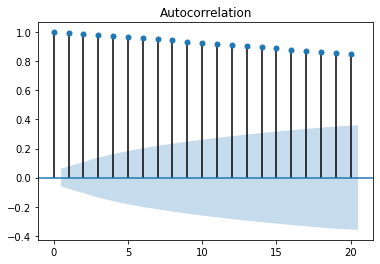

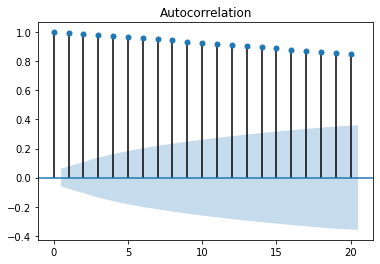

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(random_walk, lags=20)

From the above we see that autocorrelation slowly decreases as the lag increases. 

In [7]:
diff_random_walk = np.diff(random_walk, n=1)

fig = px.line(x=range(len(diff_random_walk)), y=diff_random_walk,
              labels={'x':'Value', 'y':'Timesteps'},
              title='Randomwalk of 1000 numbers')

fig.show()

In [8]:
ADF_result = adfuller(diff_random_walk)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.789310857560594
p-value: 0.0


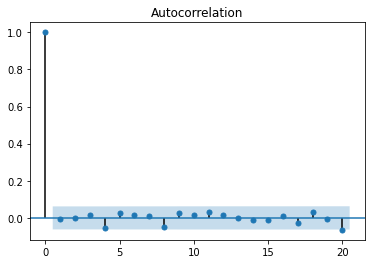

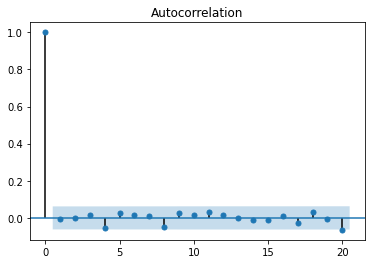

In [9]:
plot_acf(diff_random_walk, lags=20)

## Is GOOG a RandomWalk?

In [10]:
# let's get the data
file = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/GOOGL.csv'

df = pd.read_csv(file, parse_dates=['Date'])

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [11]:
fig = px.line(df,
              x='Date', y='Close',
              labels={'Close': 'Closing price (USD)'})

# we will make monthly tickmarks
fig.update_xaxes(tick0=df['Date'].min(),
                 dtick='M1')

fig.show()

In [15]:
# let's inspects the metrics
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.1602504866477126
p-value: 0.9699419435913057


In [16]:
# let's run differentiation test
diff_close = np.diff(df['Close'], n=1)

GOOGL_diff_ADF_result = adfuller(diff_close)
 
print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.303439704295234
p-value: 5.3865309614545585e-06


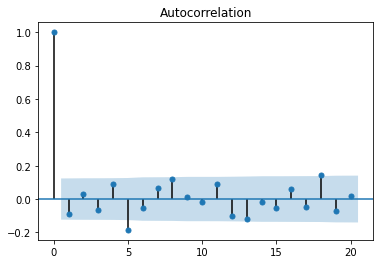

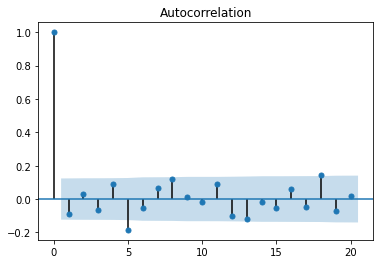

In [17]:
plot_acf(diff_close, lags=20)

#  Forecasting a Randomwalk

### Forecasting on a long horizon

In [21]:
# This is not ideal because past observations are not predictive
# however we will try to predict the last 200 steps of our randomwalk

# convert our previous randomwal data-set into a df
df = pd.DataFrame({'values': random_walk})

train = df[:800]
test = df[800:]

In [22]:
# we can only use naive forecasting
# let's try the historical mean

# compute historical mena on train data-set
mean = train['values'].mean()

# add the mean as a new column to the test data-set
test.insert(loc=test.shape[1], column='pred_mean', value=mean)

# check
test.head()

,values,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


In [31]:
# we could also use the last available values as predictor instead
last_value = train.iloc[-1,-1]

# add it to test
test.insert(loc=test.shape[1], column='pred_last', value=last_value)

# check
test.head()

,values,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


We will use the drif method

$slope = \frac {\Delta y} {\Delta x}$

In [36]:
# delta y is last and first elements of the value series
delta_y = train['values'].iloc[-1] - train['values'].iloc[0]

# compue delta x, since is just steps that coincide with the index
# we just access last and first indices
delta_x = train.index[-1] - train.index[0]

# the drift is the slope
drift = delta_y / delta_x

# check
print(f'Delta Y: {delta_y}')
print(f'Delta X: {delta_x}')
print(f'Drift: {drift}')

Delta Y: -6.814947499255865
Delta X: 799
Drift: -0.008529346056640632


In [45]:
# we now multiply the drift to the 200 steps we will predict

# add it to test
test.insert(loc=test.shape[1], column='pred_drift', value=test.index * drift)

# check
test.head()

,values,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.823477
801,-6.392708,-3.677206,-6.814947,-6.832006
802,-6.296588,-3.677206,-6.814947,-6.840536
803,-6.758863,-3.677206,-6.814947,-6.849065
804,-7.193359,-3.677206,-6.814947,-6.857594


In [64]:
# let's chart, but before we reshape data to use only one df in Plotly

# one data set to chart
result_df = pd.concat([train, test], axis='rows')

# add the index as column, but starting at 1 instea dof 0
result_df.insert(loc=result_df.shape[1], column='Step', value=result_df.index+1)

melted_result = result_df.melt(id_vars='Step', value_vars=result_df.columns[:-1].to_list())
melted_result.head()


,Step,variable,value
0,1,values,0.000000
1,2,values,-0.138264
2,3,values,0.509424
3,4,values,2.032454
4,5,values,1.798301


In [65]:
melted_result['variable'].value_counts()

values        1000
pred_mean     1000
pred_last     1000
pred_drift    1000
Name: variable, dtype: int64

In [71]:
# is chart time

fig = px.line(melted_result, x='Step', y='value',
              color='variable', line_dash='variable')

# add vertical rectangle to highlight prediction period
fig.add_vrect(x0=800, x1=1000, line_width=0, fillcolor="grey", opacity=0.2)

fig.show()

## Forecasting the next timestep